In [2]:
options(warn = -1)
options(scipen = 100)
library(nnet)
library(party)
library(randomForest)
library(e1071)
library(caret)
library(dplyr)
library(Metrics)

Loading required package: grid
Loading required package: mvtnorm
Loading required package: modeltools
Loading required package: stats4
Loading required package: strucchange
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: sandwich
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.
Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: 'ggplot2'

The following object is masked from 'package:randomForest':

    margin


Attaching package: 'dplyr'

The following object is masked from 'package:randomForest':

    combine

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, 

In [3]:
# 정확도 (결정계수)
rsquare <- function(pred, y) {
    return (1- (sum((y-pred)^2) / sum((y-mean(y))^2)))
}

# 인공 신경망
f.nnet <- function(data.tr, x, y) {
    model.nnet <- nnet(누적관객수 ~ ., data=data.tr, size = 10, linout = T) 
    pred <- predict(model.nnet, x, type = "raw")
    return (rsquare(pred,y))
}

# 의사 결정 나무
f.ctree <- function(data.tr, x, y) {
    model.ctree <- ctree(누적관객수 ~ ., data=data.tr)
    pred <- predict(model.ctree, x)
    return (rsquare(pred,y))
}

# RandomForest
f.randomForest <- function(data.tr, x, y) {
    model.rf <- randomForest(누적관객수 ~ ., data=data.tr, ntree=100)
    pred <- predict(model.rf, x)
    return (rsquare(pred,y))
}


# SVM
f.svm <- function(data.tr, x, y) {
    model.svm <- svm(누적관객수 ~., data=data.tr)
    pred <- predict(model.svm, x)
    return (rsquare(pred,y))
}

# 다항 로지스틱 회귀분석
f.multinom <- function(data.tr, x, y) {
    model.multinom <- multinom(누적관객수 ~ ., data=data.tr)
    pred <- predict(model.multinom, x)
    return (rsquare(pred,y))
}


In [4]:
temp <- read.csv("./fortest2.csv", fileEncoding = "utf-8")
data <- read.csv("./fortest1.csv", fileEncoding = "utf-8")

In [5]:
data <- cbind(data,조연점수=temp$조연점수 )
data <- subset(data, select = -c(cluster, 배우점수2, 배우점수3, 배우점수4, 배우점수5))

In [6]:
data

누적관객수,스크린점유율,배급사점수,장르_관객점수부여,감독_배우시너지,감독점수,배우점수,조연점수
4039891,23.79760,2,10,3,3.000000,4.000000,8.000000
3678156,48.26242,2,10,8,2.000000,8.250000,12.250000
3117859,36.90476,1,10,0,2.333333,4.000000,10.600000
4313101,35.27944,3,10,3,3.571429,6.777778,10.600000
3024666,21.64329,3,10,0,3.500000,7.666667,14.500000
4111237,28.49592,2,20,6,3.500000,6.500000,11.500000
3134421,18.14320,1,10,1,3.571429,6.777778,7.900000
3755233,40.17705,3,10,5,1.500000,11.750000,10.250000
3587182,34.01942,1,10,7,4.000000,4.000000,8.000000
3420172,32.55022,3,10,4,4.000000,11.375000,7.000000


In [7]:
result <- rep(0,5)
temp <- rep(0,5)
n <- 55
samp <- createDataPartition(data$누적관객수, p = 0.7, list = F)
for (i in 1:n) {


    # 학습용 데이터 셋
    data.tr <- data[samp,]

    # 검증용 데이터셋
    data.test <- data[-samp,]

    # 문제 및 정답 만들기
    x <- subset(data.test, select = -누적관객수)
    y <- data.test$누적관객수
    result[1] <- result[1] + f.nnet(data.tr, x, y)
    result[2] <- result[2] + f.ctree(data.tr, x, y)
    result[3] <- result[3] + f.randomForest(data.tr, x, y)
    result[4] <- result[4] + f.svm(data.tr, x, y)
    result[5] <- result[5] + f.multinom(data.tr, x, y)
    
    temp[1] <- temp[1] + f.nnet(data.tr, subset(data.tr, select = -누적관객수), data.tr$누적관객수)
    temp[2] <- temp[2] + f.ctree(data.tr, subset(data.tr, select = -누적관객수), data.tr$누적관객수)
    temp[3] <- temp[3] + f.randomForest(data.tr, subset(data.tr, select = -누적관객수), data.tr$누적관객수)
    temp[4] <- temp[4] + f.svm(data.tr, subset(data.tr, select = -누적관객수), data.tr$누적관객수)
    temp[5] <- temp[5] + f.multinom(data.tr, subset(data.tr, select = -누적관객수), data.tr$누적관객수)
}
result <- result / n
temp <- temp / n

# weights:  91
initial  value 2312473596725358.500000 
final  value 226665965518912.343750 
converged
# weights:  684 (600 variable)
initial  value 329.135734 
iter  10 value 193.840095
iter  20 value 155.226095
iter  30 value 126.813368
iter  40 value 99.392367
iter  50 value 74.781402
iter  60 value 51.506479
iter  70 value 37.787713
iter  80 value 27.934478
iter  90 value 14.710577
iter 100 value 0.518171
final  value 0.518171 
stopped after 100 iterations
# weights:  91
initial  value 2312472935476746.000000 
final  value 226665965518912.343750 
converged
# weights:  684 (600 variable)
initial  value 329.135734 
iter  10 value 193.840095
iter  20 value 155.226095
iter  30 value 126.813368
iter  40 value 99.392367
iter  50 value 74.781402
iter  60 value 51.506479
iter  70 value 37.787713
iter  80 value 27.934478
iter  90 value 14.710577
iter 100 value 0.518171
final  value 0.518171 
stopped after 100 iterations
# weights:  91
initial  value 2312474030775146.000000 
final  value 2266

initial  value 2312472889737235.500000 
final  value 226665965518912.281250 
converged
# weights:  684 (600 variable)
initial  value 329.135734 
iter  10 value 193.840095
iter  20 value 155.226095
iter  30 value 126.813368
iter  40 value 99.392367
iter  50 value 74.781402
iter  60 value 51.506479
iter  70 value 37.787713
iter  80 value 27.934478
iter  90 value 14.710577
iter 100 value 0.518171
final  value 0.518171 
stopped after 100 iterations
# weights:  91
initial  value 2312472386544745.500000 
final  value 226665965518912.281250 
converged
# weights:  684 (600 variable)
initial  value 329.135734 
iter  10 value 193.840095
iter  20 value 155.226095
iter  30 value 126.813368
iter  40 value 99.392367
iter  50 value 74.781402
iter  60 value 51.506479
iter  70 value 37.787713
iter  80 value 27.934478
iter  90 value 14.710577
iter 100 value 0.518171
final  value 0.518171 
stopped after 100 iterations
# weights:  91
initial  value 2312471743505145.500000 
final  value 226665965518912.281

initial  value 329.135734 
iter  10 value 193.840095
iter  20 value 155.226095
iter  30 value 126.813368
iter  40 value 99.392367
iter  50 value 74.781402
iter  60 value 51.506479
iter  70 value 37.787713
iter  80 value 27.934478
iter  90 value 14.710577
iter 100 value 0.518171
final  value 0.518171 
stopped after 100 iterations
# weights:  91
initial  value 2312472695474870.000000 
iter  10 value 227103169937468.656250
iter  20 value 210258625469230.656250
iter  30 value 184263009241587.718750
iter  40 value 93346329994776.453125
iter  50 value 84901503445372.375000
iter  60 value 84157599268077.156250
iter  70 value 82992503995664.437500
iter  80 value 73541021839643.296875
iter  90 value 72403420483172.687500
iter 100 value 72248349799598.640625
final  value 72248349799598.640625 
stopped after 100 iterations
# weights:  684 (600 variable)
initial  value 329.135734 
iter  10 value 193.840095
iter  20 value 155.226095
iter  30 value 126.813368
iter  40 value 99.392367
iter  50 value 

initial  value 329.135734 
iter  10 value 193.840095
iter  20 value 155.226095
iter  30 value 126.813368
iter  40 value 99.392367
iter  50 value 74.781402
iter  60 value 51.506479
iter  70 value 37.787713
iter  80 value 27.934478
iter  90 value 14.710577
iter 100 value 0.518171
final  value 0.518171 
stopped after 100 iterations
# weights:  91
initial  value 2312470892866520.500000 
final  value 226665965518912.312500 
converged
# weights:  684 (600 variable)
initial  value 329.135734 
iter  10 value 193.840095
iter  20 value 155.226095
iter  30 value 126.813368
iter  40 value 99.392367
iter  50 value 74.781402
iter  60 value 51.506479
iter  70 value 37.787713
iter  80 value 27.934478
iter  90 value 14.710577
iter 100 value 0.518171
final  value 0.518171 
stopped after 100 iterations
# weights:  91
initial  value 2312472948123745.000000 
final  value 226665965518912.281250 
converged
# weights:  684 (600 variable)
initial  value 329.135734 
iter  10 value 193.840095
iter  20 value 155.

initial  value 329.135734 
iter  10 value 193.840095
iter  20 value 155.226095
iter  30 value 126.813368
iter  40 value 99.392367
iter  50 value 74.781402
iter  60 value 51.506479
iter  70 value 37.787713
iter  80 value 27.934478
iter  90 value 14.710577
iter 100 value 0.518171
final  value 0.518171 
stopped after 100 iterations
# weights:  91
initial  value 2312473891727442.000000 
final  value 226665965518912.312500 
converged
# weights:  684 (600 variable)
initial  value 329.135734 
iter  10 value 193.840095
iter  20 value 155.226095
iter  30 value 126.813368
iter  40 value 99.392367
iter  50 value 74.781402
iter  60 value 51.506479
iter  70 value 37.787713
iter  80 value 27.934478
iter  90 value 14.710577
iter 100 value 0.518171
final  value 0.518171 
stopped after 100 iterations
# weights:  91
initial  value 2312472793067806.000000 
final  value 226665965518912.343750 
converged
# weights:  684 (600 variable)
initial  value 329.135734 
iter  10 value 193.840095
iter  20 value 155.

initial  value 2312473205039151.500000 
final  value 226665965518912.375000 
converged
# weights:  684 (600 variable)
initial  value 329.135734 
iter  10 value 193.840095
iter  20 value 155.226095
iter  30 value 126.813368
iter  40 value 99.392367
iter  50 value 74.781402
iter  60 value 51.506479
iter  70 value 37.787713
iter  80 value 27.934478
iter  90 value 14.710577
iter 100 value 0.518171
final  value 0.518171 
stopped after 100 iterations
# weights:  91
initial  value 2312474129160263.000000 
final  value 226665965518912.312500 
converged
# weights:  684 (600 variable)
initial  value 329.135734 
iter  10 value 193.840095
iter  20 value 155.226095
iter  30 value 126.813368
iter  40 value 99.392367
iter  50 value 74.781402
iter  60 value 51.506479
iter  70 value 37.787713
iter  80 value 27.934478
iter  90 value 14.710577
iter 100 value 0.518171
final  value 0.518171 
stopped after 100 iterations
# weights:  91
initial  value 2312473445459771.500000 
iter  10 value 220083925706685.2

initial  value 329.135734 
iter  10 value 193.840095
iter  20 value 155.226095
iter  30 value 126.813368
iter  40 value 99.392367
iter  50 value 74.781402
iter  60 value 51.506479
iter  70 value 37.787713
iter  80 value 27.934478
iter  90 value 14.710577
iter 100 value 0.518171
final  value 0.518171 
stopped after 100 iterations
# weights:  91
initial  value 2312472991897570.000000 
final  value 226665965518912.343750 
converged
# weights:  684 (600 variable)
initial  value 329.135734 
iter  10 value 193.840095
iter  20 value 155.226095
iter  30 value 126.813368
iter  40 value 99.392367
iter  50 value 74.781402
iter  60 value 51.506479
iter  70 value 37.787713
iter  80 value 27.934478
iter  90 value 14.710577
iter 100 value 0.518171
final  value 0.518171 
stopped after 100 iterations
# weights:  91
initial  value 2312474419893505.000000 
final  value 226665965518912.250000 
converged
# weights:  684 (600 variable)
initial  value 329.135734 
iter  10 value 193.840095
iter  20 value 155.

In [8]:
res_all <- rbind(t(as.data.frame(temp)),
t(as.data.frame(result)))
colnames(res_all) <- c("인공신경망", "의사결정나무", "randomForest", "SVM", "다항로지스틱회귀분석")
rownames(res_all) <- c("트레이닝", "테스트")
res_all

,인공신경망,의사결정나무,randomForest,SVM,다항로지스틱회귀분석
트레이닝,0.04836203,0.6011842,0.9157188,0.8018423,NA
테스트,0.01137942,0.3520210,0.6315185,0.4945398,NA


In [11]:
dreg <- lm(누적관객수~., subset(data, selec = -c(배급사점수, 감독_배우시너지)))
summary(dreg)


Call:
lm(formula = 누적관객수 ~ ., data = subset(data, selec = -c(배급사점수, 
    감독_배우시너지)))

Residuals:
     Min       1Q   Median       3Q      Max 
-3015988  -687038  -138074   674140  2571756 

Coefficients:
                  Estimate Std. Error t value  Pr(>|t|)    
(Intercept)        -477870     495181  -0.965  0.336807    
스크린점유율         27521      10506   2.619  0.010152 *  
장르_관객점수부여    37696      20831   1.810  0.073300 .  
감독점수            225512      54896   4.108 0.0000807 ***
배우점수            105232      30647   3.434  0.000862 ***
조연점수            152166      39062   3.895  0.000175 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1128000 on 102 degrees of freedom
Multiple R-squared:  0.5985,	Adjusted R-squared:  0.5788 
F-statistic: 30.41 on 5 and 102 DF,  p-value: < 0.00000000000000022


In [13]:
cor(data)

,감독_배우시너지,스크린점유율,감독점수,장르_관객점수부여,배우점수,배급사점수,누적관객수
감독_배우시너지,1.0000000,0.399213876,0.212846355,0.1664057,0.1543465,0.1994144,0.3214885
스크린점유율,0.3992139,1.000000000,-0.007764333,0.2715250,0.3664339,0.2673891,0.4244191
감독점수,0.2128464,-0.007764333,1.000000000,0.1773735,0.2629795,0.3386887,0.4713020
장르_관객점수부여,0.1664057,0.271525037,0.177373536,1.0000000,0.1380842,0.1932876,0.3664407
배우점수,0.1543465,0.366433865,0.262979461,0.1380842,1.0000000,0.4741871,0.5654847
배급사점수,0.1994144,0.267389100,0.338688702,0.1932876,0.4741871,1.0000000,0.6063415
누적관객수,0.3214885,0.424419051,0.471301950,0.3664407,0.5654847,0.6063415,1.0000000


In [14]:
lreg <- subset(data, select = c(누적관객수, 배우점수, 스크린점유율, 감독점수, 장르_관객점수부여))

In [15]:
a <- lm(누적관객수~., lreg)

In [16]:
summary(a)


Call:
lm(formula = 누적관객수 ~ ., data = lreg)

Residuals:
     Min       1Q   Median       3Q      Max 
-2849384  -809100   -91388   698866  2711543 

Coefficients:
                  Estimate Std. Error t value   Pr(>|t|)    
(Intercept)         207155     493731   0.420    0.67567    
배우점수            146677      30655   4.785 0.00000573 ***
스크린점유율         35721      10979   3.254    0.00154 ** 
감독점수            276404      56870   4.860 0.00000421 ***
장르_관객점수부여    57621      21538   2.675    0.00869 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1203000 on 103 degrees of freedom
Multiple R-squared:  0.5387,	Adjusted R-squared:  0.5208 
F-statistic: 30.08 on 4 and 103 DF,  p-value: < 0.00000000000000022


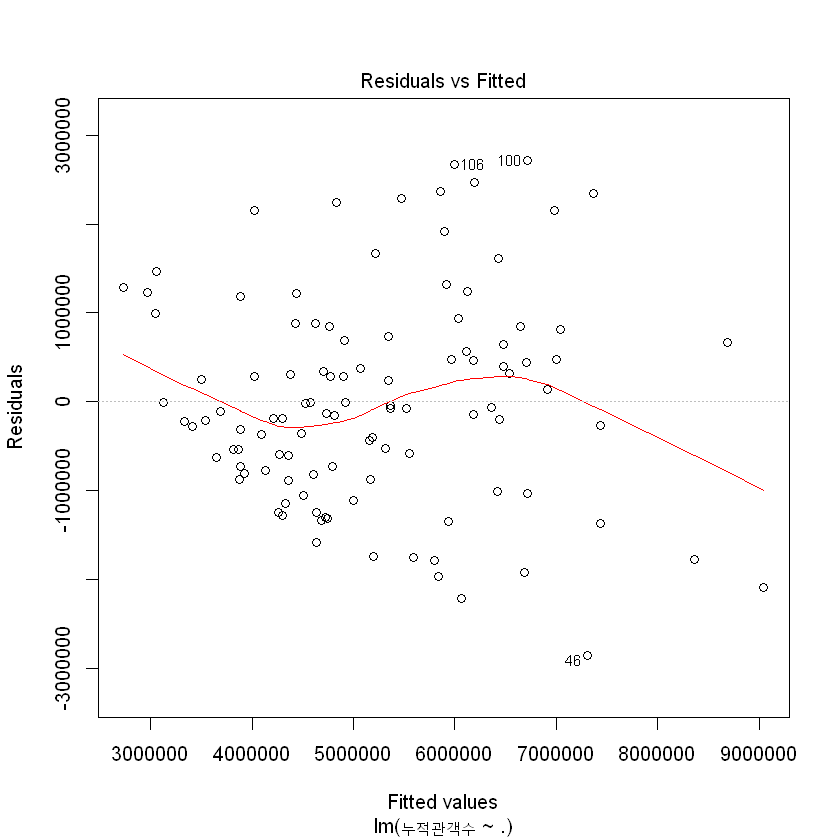

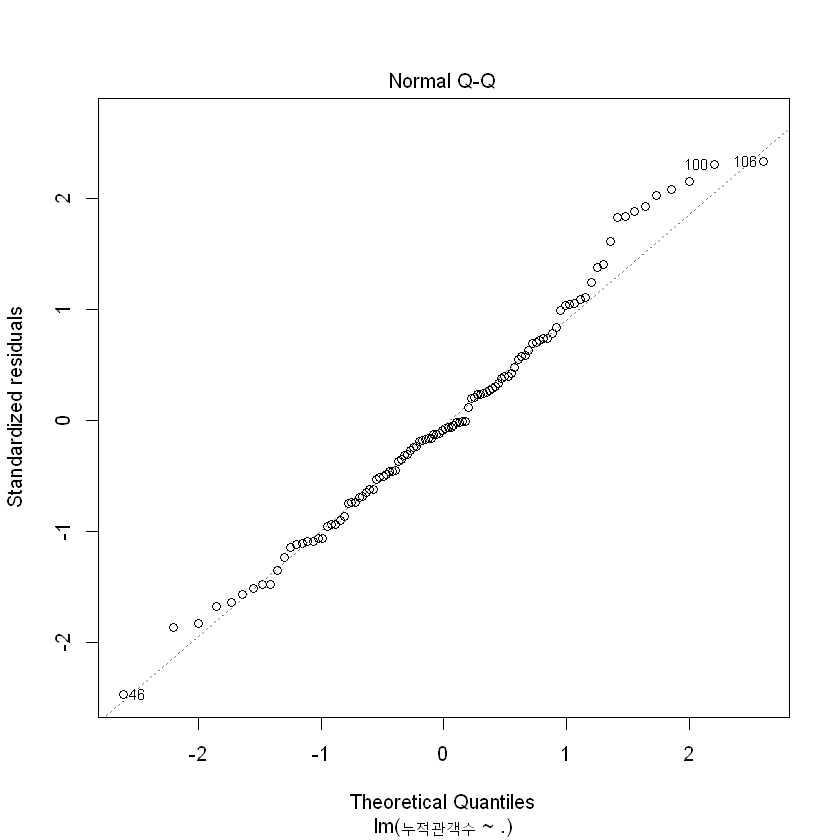

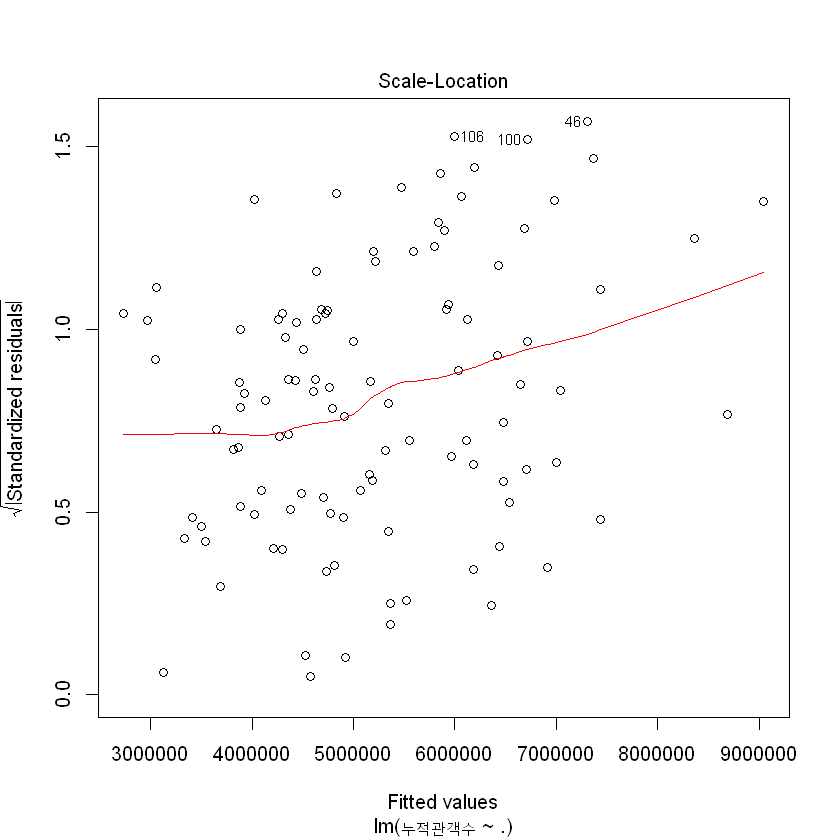

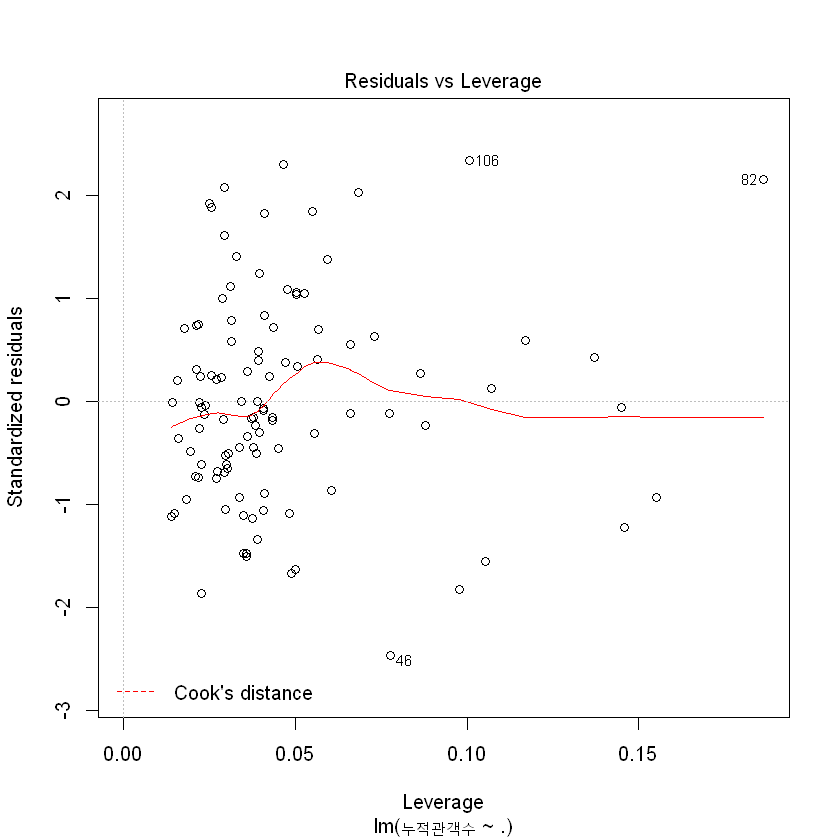

In [17]:
plot(a)

In [18]:
set_one <- subset(data[data$cluster == 1,],select = c(누적관객수, 배우점수, 스크린점유율, 감독점수, 장르_관객점수부여, 감독_배우시너지))
set_two <- subset(data[data$cluster == 2,],select = c(누적관객수, 배우점수, 스크린점유율, 감독점수, 장르_관객점수부여, 감독_배우시너지))
set_three <- subset(data[data$cluster == 3,],select = c(누적관객수, 배우점수, 스크린점유율, 감독점수, 장르_관객점수부여, 감독_배우시너지))

In [19]:
one <- lm(누적관객수~., set_one)
two <- lm(누적관객수~., set_two)
three <- lm(누적관객수~., set_three)
summary(one)
summary(two)
summary(three)

ERROR: Error in lm.fit(x, y, offset = offset, singular.ok = singular.ok, ...): 0 (non-NA) cases


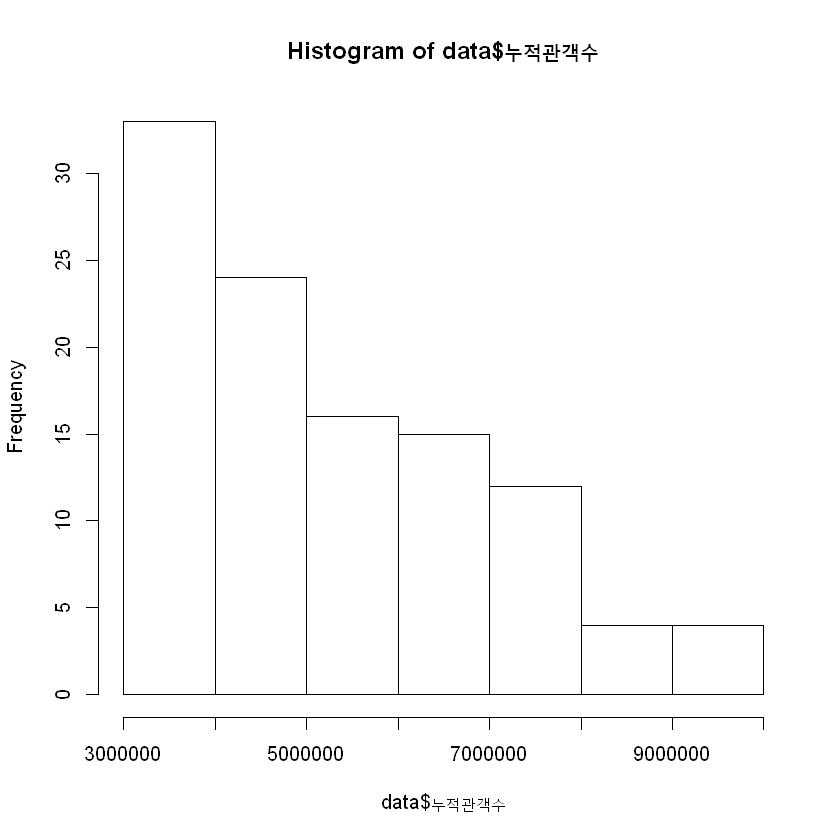

In [21]:
hist(data$누적관객수)

In [22]:
test <- subset(data[data$누적관객수 > 8000000 & data$누적관객수 < 10000000,],select = c(누적관객수, 배우점수, 스크린점유율, 감독점수, 장르_관객점수부여, 감독_배우시너지))

In [23]:
test <- subset(data[data$누적관객수 > 3000000 & data$누적관객수 < 4000000,],select = c(누적관객수, 배급사점수, 배우점수, 스크린점유율, 감독점수, 장르_관객점수부여, 감독_배우시너지))
nrow(test)
tt <- lm(누적관객수~., test)
summary(tt)
print("--------------------------------------------")
test <- subset(data[data$누적관객수 > 4000000 & data$누적관객수 < 5000000,],select = c(누적관객수, 배급사점수, 배우점수, 스크린점유율, 감독점수, 장르_관객점수부여, 감독_배우시너지))
nrow(test)
tt <- lm(누적관객수~., test)
summary(tt)
print("--------------------------------------------")
test <- subset(data[data$누적관객수 > 5000000 & data$누적관객수 < 7000000,],select = c(누적관객수, 배급사점수, 배우점수, 스크린점유율, 감독점수, 장르_관객점수부여, 감독_배우시너지))
nrow(test)
tt <- lm(누적관객수~., test)
summary(tt)
print("--------------------------------------------")
test <- subset(data[data$누적관객수 > 7000000 & data$누적관객수 < 8000000,],select = c(누적관객수, 배급사점수, 배우점수, 스크린점유율, 감독점수, 장르_관객점수부여, 감독_배우시너지))
nrow(test)
tt <- lm(누적관객수~., test)
summary(tt)
print("--------------------------------------------")
test <- subset(data[data$누적관객수 > 8000000 & data$누적관객수 < 10000000,],select = c(누적관객수, 배급사점수, 배우점수, 스크린점유율, 감독점수, 장르_관객점수부여, 감독_배우시너지))
nrow(test)
tt <- lm(누적관객수~., test)
summary(tt)

[1] 33


Call:
lm(formula = 누적관객수 ~ ., data = test)

Residuals:
    Min      1Q  Median      3Q     Max 
-296987  -71273   32394   90490  267124 

Coefficients:
                   Estimate Std. Error t value           Pr(>|t|)    
(Intercept)       2811519.2   182144.5  15.436 0.0000000000000132 ***
배급사점수         -63569.4    42095.7  -1.510           0.143072    
배우점수            30577.8     7647.5   3.998           0.000469 ***
스크린점유율          472.2     3646.3   0.130           0.897951    
감독점수           -11905.0    24560.0  -0.485           0.631927    
장르_관객점수부여   18639.6     7510.2   2.482           0.019854 *  
감독_배우시너지     65860.7     9623.3   6.844 0.0000002896181992 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 140500 on 26 degrees of freedom
Multiple R-squared:  0.8085,	Adjusted R-squared:  0.7643 
F-statistic: 18.29 on 6 and 26 DF,  p-value: 0.00000003312


[1] "--------------------------------------------"


[1] 24


Call:
lm(formula = 누적관객수 ~ ., data = test)

Residuals:
    Min      1Q  Median      3Q     Max 
-253773 -105445  -35214   80352  426860 

Coefficients:
                  Estimate Std. Error t value          Pr(>|t|)    
(Intercept)        3510702     183925  19.088 0.000000000000641 ***
배급사점수          292563      66104   4.426           0.00037 ***
배우점수             22363      13728   1.629           0.12171    
스크린점유율          5056       4587   1.102           0.28573    
감독점수            -19594      23279  -0.842           0.41165    
장르_관객점수부여    15911      11523   1.381           0.18524    
감독_배우시너지     -51818      21524  -2.407           0.02771 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 178700 on 17 degrees of freedom
Multiple R-squared:  0.7605,	Adjusted R-squared:  0.6759 
F-statistic: 8.995 on 6 and 17 DF,  p-value: 0.0001634


[1] "--------------------------------------------"


[1] 31


Call:
lm(formula = 누적관객수 ~ ., data = test)

Residuals:
    Min      1Q  Median      3Q     Max 
-710674 -317166 -137225  230766 1214841 

Coefficients: (1 not defined because of singularities)
                  Estimate Std. Error t value      Pr(>|t|)    
(Intercept)        4167463     491532   8.479 0.00000000802 ***
배급사점수              NA         NA      NA            NA    
배우점수             66675      26281   2.537        0.0178 *  
스크린점유율          9219       8974   1.027        0.3141    
감독점수             49385      38544   1.281        0.2119    
장르_관객점수부여    35525      15524   2.288        0.0308 *  
감독_배우시너지     -31123      33605  -0.926        0.3632    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 508100 on 25 degrees of freedom
Multiple R-squared:  0.4763,	Adjusted R-squared:  0.3716 
F-statistic: 4.548 on 5 and 25 DF,  p-value: 0.004371


[1] "--------------------------------------------"


[1] 12


Call:
lm(formula = 누적관객수 ~ ., data = test)

Residuals:
    Min      1Q  Median      3Q     Max 
-313027  -75814    6179   97421  253071 

Coefficients: (1 not defined because of singularities)
                  Estimate Std. Error t value Pr(>|t|)   
(Intercept)        5485351    1225562   4.476  0.00421 **
배급사점수              NA         NA      NA       NA   
배우점수            -36368      20522  -1.772  0.12674   
스크린점유율         32049      19004   1.686  0.14269   
감독점수            240149      87430   2.747  0.03343 * 
장르_관객점수부여    -3697      10750  -0.344  0.74266   
감독_배우시너지     -10979      29527  -0.372  0.72280   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 202500 on 6 degrees of freedom
Multiple R-squared:  0.7477,	Adjusted R-squared:  0.5374 
F-statistic: 3.556 on 5 and 6 DF,  p-value: 0.07707


[1] "--------------------------------------------"


[1] 8


Call:
lm(formula = 누적관객수 ~ ., data = test)

Residuals:
     82      85      86      87      97      98     100     106 
 -54139  130191 -187263 -267747   83586   74634  210692   10046 

Coefficients: (1 not defined because of singularities)
                  Estimate Std. Error t value Pr(>|t|)  
(Intercept)        7759966    1460432   5.313   0.0336 *
배급사점수              NA         NA      NA       NA  
배우점수            -15176      49715  -0.305   0.7890  
스크린점유율         36416       7663   4.752   0.0415 *
감독점수             79740      81153   0.983   0.4294  
장르_관객점수부여    12310      15174   0.811   0.5024  
감독_배우시너지    -123814     145328  -0.852   0.4840  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 303100 on 2 degrees of freedom
Multiple R-squared:  0.9267,	Adjusted R-squared:  0.7435 
F-statistic: 5.057 on 5 and 2 DF,  p-value: 0.1733


In [67]:
test <- subset(data[(data$누적관객수 > 3000000 & data$누적관객수 < 4000000) | (data$누적관객수 > 8000000 & data$누적관객수 < 10000000),],select = c(누적관객수, 배급사점수, 배우점수, 스크린점유율, 감독점수, 장르_관객점수부여, 감독_배우시너지))
nrow(test)

tt <- lm(누적관객수~., test)
summary(tt)

[1] 41


Call:
lm(formula = 누적관객수 ~ ., data = test)

Residuals:
     Min       1Q   Median       3Q      Max 
-2025407  -690446   -22829   568517  2381000 

Coefficients:
                      Estimate   Std. Error t value Pr(>|t|)   
(Intercept)       -1597965.105  2436597.633  -0.656  0.51663   
배급사점수          538583.725   319262.451   1.687  0.10134   
배우점수            136025.293    53735.844   2.531  0.01647 * 
스크린점유율         24088.913    62277.465   0.387  0.70146   
감독점수            472405.910   135466.004   3.487  0.00144 **
장르_관객점수부여   -70947.954   195889.154  -0.362  0.71960   
감독_배우시너지     144898.974    72693.898   1.993  0.05482 . 
ccc                   2202.628     5178.096   0.425  0.67341   
ddd                     -9.996       32.725  -0.305  0.76199   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1131000 on 32 degrees of freedom
Multiple R-squared:  0.7945,	Adjusted R-squared:  0.7431 
F-statistic: 15.47 on 8 and 32 DF,  p-value: 0.

In [ ]:
test$ccc <- test$장르_관객점수부여 * test$스크린점유율
test$ddd <- test$장르_관객점수부여 * test$감독점수

In [84]:
test <- subset(data[data$누적관객수 > 4000000 & data$누적관객수 < 8000000,],select = c(누적관객수, 배급사점수, 배우점수, 스크린점유율, 감독점수, 장르_관객점수부여, 감독_배우시너지))
nrow(test)
test$ccc <- (test$장르_관객점수부여 * test$스크린점유율)
test$ddd <- (test$장르_관객점수부여 * test$감독점수)^2
test$aaa <- test$감독점수^2

tt <- lm(누적관객수~., test)
summary(tt)

[1] 67


Call:
lm(formula = 누적관객수 ~ ., data = test)

Residuals:
     Min       1Q   Median       3Q      Max 
-1791494  -534089  -112901   519758  2322929 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)   
(Intercept)        1637720     651472   2.514  0.01464 * 
배급사점수          684685     230908   2.965  0.00434 **
배우점수             84839      28879   2.938  0.00469 **
스크린점유율         13367      10520   1.271  0.20880   
감독점수             88779      48037   1.848  0.06951 . 
장르_관객점수부여    47373      18381   2.577  0.01244 * 
감독_배우시너지     -90693      39290  -2.308  0.02445 * 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 826600 on 60 degrees of freedom
Multiple R-squared:  0.5379,	Adjusted R-squared:  0.4917 
F-statistic: 11.64 on 6 and 60 DF,  p-value: 0.00000001326


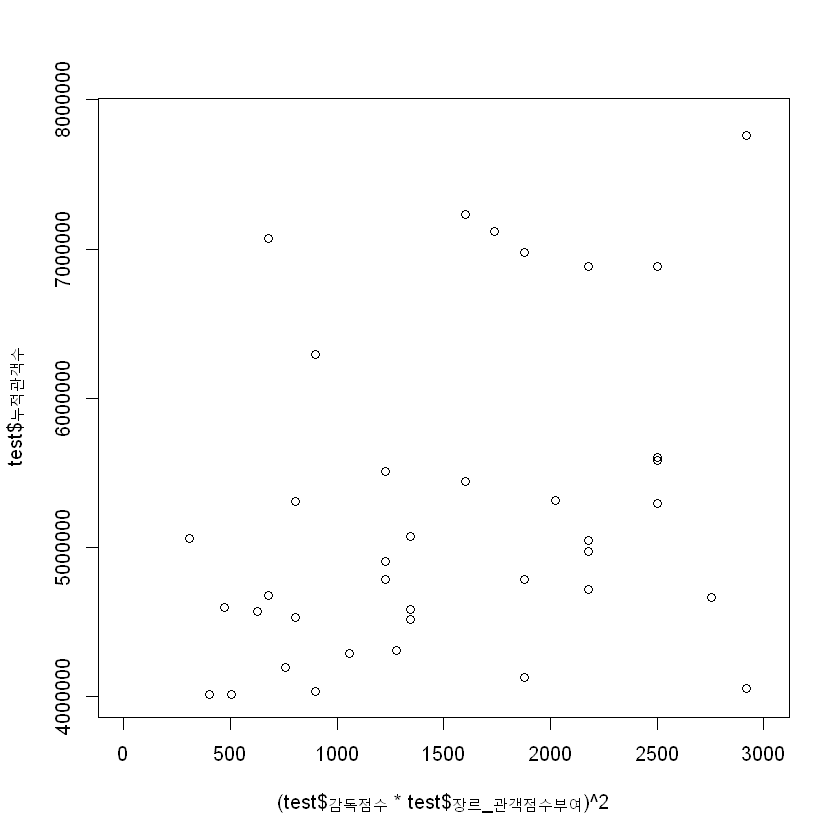

In [103]:
plot((test$감독점수 * test$장르_관객점수부여)^2,test$누적관객수, xlim = c(0,3000))